<a href="https://colab.research.google.com/github/resmyvijay/Machine-Learning-Face-Mask-Detection/blob/main/Face_mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
df = pd.read_csv("/content/train.csv")
df.head()


# New section

In [ ]:
import shutil, os
source = "/content/gdrive/MyDrive/Medical Mask/images"
destination = "/content/gdrive/MyDrive/Medical Mask/No masks"

for index, row in df.iterrows():
  if (row['classname']=='face_no_mask' and not os.path.isfile(destination + '/'+ row['name'])):
    shutil.move(source + '/'+ row['name'], destination) # add source dir to filename/content/gdrive/MyDrive/Medical Mask/images/0001.jpg

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
imagePaths = list(paths.list_images('/content/gdrive/MyDrive/Medical Mask'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
150/150 [==============================] - 268s 2s/step - loss: 0.5309 - accuracy: 0.8041 - val_loss: 0.3465 - val_accuracy: 0.8407
Epoch 2/20
150/150 [==============================] - 263s 2s/step - loss: 0.3751 - accuracy: 0.8436 - val_loss: 0.3198 - val_accuracy: 0.8515
Epoch 3/20
150/150 [==============================] - 265s 2s/step - loss: 0.3425 - accuracy: 0.8596 - val_loss: 0.3133 - val_accuracy: 0.8490
Epoch 4/20
150/150 [==============================] - 263s 2s/step - loss: 0.3378 - accuracy: 0.8533 - val_loss: 0.3038 - val_accuracy: 0.8689
Epoch 5/20
150/150 [==============================] - 265s 2s/step - loss: 0.3312 - accuracy: 0.8687 - val_loss: 0.3020 - val_accuracy: 0.8780
Epoch 6/20
150/150 [==============================] - 264s 2s/step - loss: 0.3213 - accuracy: 0.8718 - val_loss: 0.2992 - val_accuracy: 0.8747
Epoch 7/20
150/150 [==============================] - 264s 2s/step - loss: 0.3106 - accuracy

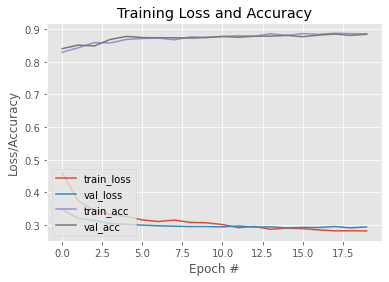

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
model.save('mask_recog_ver2.h5')

In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


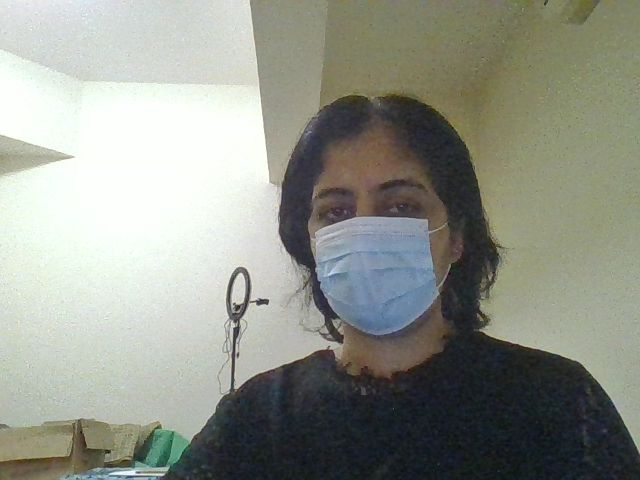

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from google.colab.patches import cv2_imshow

cascPath = "/content/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier("/content/haarcascade_frontalface_alt2.xml")
model = load_model("/content/mask_recog_ver2.h5")

src = cv2.imread("/content/photo.jpg")

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)


In [ ]:
faces_list=[]
preds=[]

In [ ]:
import cv2
import sys
# Get user supplied values

cascPath = "./haarcascade_frontalface_default.xml"
# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)
# Read the image
image = cv2.imread("/content/photo.jpg")
#cv2.imshow("Faces found", image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Detect faces in the image
faces = faceCascade.detectMultiScale(gray,1.1, 5)
print ("Found {0} faces!".format(len(faces)))
# Draw a rectangle around the faces
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
  cv2.imshow("Faces found", image)
  cv2.waitKey(0)

In [ ]:
faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)


In [ ]:
for (x, y, w, h) in faces:
        print("I am here")
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame =  preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
        #mask contain probabily of wearing a mask and vice versa
            (mask, withoutMask) = pred 

In [ ]:
label = "Mask" if mask > withoutMask else "No Mask"

print(label)
